In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import operator
import random
from numpy.random import randint
from numpy.linalg import matrix_power



## Definir o grafo

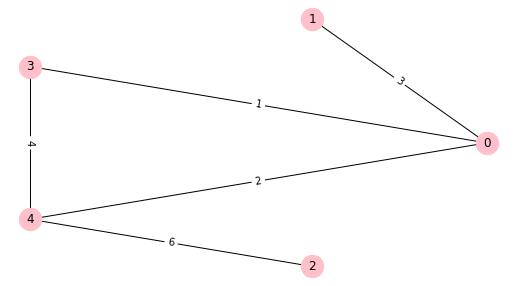

In [22]:
graph = nx.Graph()

graph.add_edge(0, 1, weight=3)
graph.add_edge(0, 3, weight=1)
graph.add_edge(0, 4, weight=2)
graph.add_edge(3, 4, weight=4)
graph.add_edge(2, 4, weight=6)


options = {
    'node_color': 'pink',
    'node_size': 500,
    'width': 1,
}

plt.figure(figsize=(9,5))

npos=nx.circular_layout(graph,scale=1)
labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos = npos,edge_labels=labels)

nx.draw(graph,pos = npos, **options, with_labels=True)
plt.show()

## Algoritmo
Cria a matriz de adjacências

In [23]:
A = nx.adjacency_matrix(graph, weight='weight', nodelist=sorted(graph.nodes()))
A.todense()

matrix([[0, 3, 0, 1, 2],
        [3, 0, 0, 0, 0],
        [0, 0, 0, 0, 6],
        [1, 0, 0, 0, 4],
        [2, 0, 6, 4, 0]])

Cria a matriz de probabilidade de transiçao

In [24]:
n = 5
P = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        P[i,j] = A[i,j]/np.sum(A[i,:])
        
print(P)

[[0.         0.5        0.         0.16666667 0.33333333]
 [1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.2        0.         0.         0.         0.8       ]
 [0.16666667 0.         0.5        0.33333333 0.        ]]


In [25]:
def check_sum_lines(n, P):
        
    for i in range(n):
        for j in range(n):

            if(not math.isclose(np.sum(P[i,:]),1)):
                print('A matriz não é estocástica')
                return False
    print('A matriz é estocástica')
    return True
    

In [26]:
check_sum_lines(5, P)

A matriz é estocástica


True

## Cálculo da distribuição estacionária

O cálculo foi feito de três formas diferentes:

1) Como a distribuição estacionária $\pi$ representa a probabilidade de chegar em cada estado após um número infinito de passos, podemos representar como: 

<img src="limite1.png" width="200">

Assim calcular o valor da P elevado a um n suficientemente grande é uma boa aproximação da distribuiçao estacionária




In [27]:
from numpy.linalg import matrix_power

power = 1000

Pn =  matrix_power(P,power)
Pn

array([[0.1875 , 0.09375, 0.1875 , 0.15625, 0.375  ],
       [0.1875 , 0.09375, 0.1875 , 0.15625, 0.375  ],
       [0.1875 , 0.09375, 0.1875 , 0.15625, 0.375  ],
       [0.1875 , 0.09375, 0.1875 , 0.15625, 0.375  ],
       [0.1875 , 0.09375, 0.1875 , 0.15625, 0.375  ]])

2) Também podemos descrever a distribuição estacionária como $\pi = \pi \cdot P$, onde $\pi$ é o autovetor com autovalor $ \lambda = 1$

In [28]:
stationary_dict = {}
# Cálculo dos autovetores e autovalores
eigvals, eigvecs = np.linalg.eig(P.T)
# Encontrar o autovetor cujo autovalor é próximo de 1
pi = eigvecs[:,np.isclose(eigvals, 1)]

stationary_dist = (pi / pi.sum()).real

for i in range(n):
    
    stationary_dict[i] = stationary_dist[i][0]
    

stationary_dict

{0: 0.1875000000000007,
 1: 0.09375000000000035,
 2: 0.1874999999999996,
 3: 0.15624999999999983,
 4: 0.37499999999999956}

3) Além disso, como a cadeia de Markov é reversível, como mostrado no livro do Sheldon Ross, Introduction to Probability Models podemos calcular utilizando a seguinte fórmula:

<img src="limite2.png" width="200">


In [29]:
pi = [ ] 
for i in range(n):
    pi.append(0)
    for j in range(n):
        
        pi[i] = np.sum(A[i,:])/np.sum(A[:,:])
print(pi)

[0.1875, 0.09375, 0.1875, 0.15625, 0.375]


In [30]:
def generate_random_from_dist(prob_dict):
    
    options = []
    
    for item, prob in prob_dict.items():
        options += int(prob*1000) * [item]
    
    return random.choice(options)


In [31]:
def generate_dict(list_for_nodes, node):
    
    d = {}
    for l in list_for_nodes:
        d[l] = P[node][l]
        
    return d

        

In [32]:
# random_node is the start node selected randomly
random_node = randint(0, n)

visit = {} #initialise the value for all nodes as 0
for i in range(n):
    visit[i] = 0
    
# inicializa o primeiro elemento que será visitado
visit[random_node] = visit[random_node]+1

steps = 10000
   
for i in range(steps):
    
    # encontra todas os possíveis vizinhos do vertice
    list_for_nodes = list(graph.neighbors(random_node))

    # escolhe o próximo passo randomicamente dentre os possiveis vizinhos
    prob_dict = generate_dict(list_for_nodes,random_node)
    random_node = generate_random_from_dist(prob_dict)
    visit[random_node] = visit[random_node] + 1
        


In [33]:
print(sorted(visit.items(), key=operator.itemgetter(1),reverse=True))
print(sorted(stationary_dict.items(), key=operator.itemgetter(1),reverse=True))


[(4, 3770), (2, 1892), (0, 1838), (3, 1558), (1, 943)]
[(4, 0.37499999999999956), (0, 0.1875000000000007), (2, 0.1874999999999996), (3, 0.15624999999999983), (1, 0.09375000000000035)]


In [34]:
percentual_visit = {} 

for key in visit:
   percentual_visit[key] = visit[key]/steps

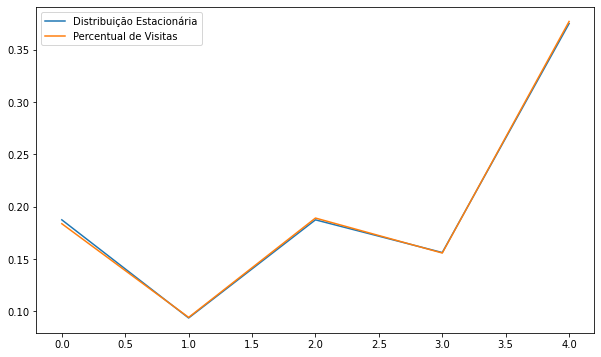

In [36]:
plt.figure(figsize=(10,6))

D = stationary_dict
lists = sorted(D.items()) 
x, y = zip(*lists) 
plt.plot(x, y,label = 'Distribuição Estacionária')

D = percentual_visit
lists = sorted(D.items()) 
x, y = zip(*lists)
plt.plot(x, y,label = 'Percentual de Visitas')

plt.legend()
plt.show()
